In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#libraries required for the modelling
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler #
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

#mapping 
from keplergl import KeplerGl

#times series data handling 
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose

#for visualizations
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

import os
working_directory=os.getcwd()
print(working_directory)

/Users/lindomavimbela/Downloads/archive


In [2]:
#project questions to be answered
# 1.What are the trends in listings over the years from owners and customers?
# 2.What specific locations and property types do clients prefer?
# 3.How have the prices changed over the years ?
# 4.What are the earnings in specific areas?
# 5.Model the nightly price

In [3]:
#Key Steps for Project
#Feel free to be creative with your solutions, but do follow the CRISP-DM process in finding your solutions.

#1) Pick a dataset.

#2) Pose at least three questions related to business or real-world applications of how the data could be used.

#3) Create a Jupyter Notebook, using any associated packages you'd like, to:

#Prepare data:

#Gather necessary data to answer your questions
#Handle categorical and missing data
#Provide insight into the methods you chose and why you chose them
#Analyze, Model, and Visualize

#Provide a clear connection between your business questions and how the data answers them.
#4) Communicate your business insights:

#Create a Github repository to share your code and data wrangling/modeling techniques, with a technical audience in mind
#Create a blog post to share your questions and insights with a non-technical audience

#Your deliverables will be a Github repo and a blog post. Use the rubric here to assist in successfully completing this project!

In [4]:
# data gathering 
df_calendar=pd.read_csv(working_directory +'/calendar.csv')
df_listings=pd.read_csv(working_directory +'/listings.csv')
df_reviews=pd.read_csv(working_directory +'/reviews.csv')

In [6]:
#firtly we take a glimpes at the the different data sets loaded
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1393570 entries, 0 to 1393569
Data columns (total 4 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   listing_id  1393570 non-null  int64 
 1   date        1393570 non-null  object
 2   available   1393570 non-null  object
 3   price       934542 non-null   object
dtypes: int64(1), object(3)
memory usage: 42.5+ MB


In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84849 entries, 0 to 84848
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   listing_id     84849 non-null  int64 
 1   id             84849 non-null  int64 
 2   date           84849 non-null  object
 3   reviewer_id    84849 non-null  int64 
 4   reviewer_name  84849 non-null  object
 5   comments       84831 non-null  object
dtypes: int64(3), object(3)
memory usage: 3.9+ MB


In [8]:
df_listings.head(2)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48


In [10]:
df_listings.isna().sum()

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64

In [11]:
#validating the size of the data 
num_rows = df_listings.shape[0] #Provide the number of rows in the dataset
num_cols = df_listings.shape[1] #Provide the number of columns in the dataset

print(num_rows,num_cols)

3818 92


In [12]:
no_nulls = set(df_listings.columns[df_listings.isnull().mean()==0])#Provide a set of columns with 0 missing values.
no_nulls_view=len(no_nulls)/df_listings.shape[1] #percentage of columns with no_nulls compared to the total number of columns
no_nulls_view

#almost half of the columns in the data contain nulls

0.5108695652173914

In [13]:
missing_cols = set(df_listings.columns[df_listings.isnull().mean() >0.5])#set of columns with more than 50% of the values missing
missing_cols

{'license', 'monthly_price', 'security_deposit', 'square_feet'}

In [14]:
missing_cols = set(df_listings.columns[df_listings.isnull().mean() >0.75])#set of columns with more than 75% of the values missing
missing_cols

{'license', 'square_feet'}

In [15]:
# drop columns with more than 75% of the data missing
cols_to_drop = ['license','square_feet'] #more than 75% of the data missing 
df_list_new = df_listings.drop(cols_to_drop, axis=1)

In [17]:
# based on the objective of the study, we dont have to clean every single column or row in the data set
# We can already identify some columns that wont be necessary for the study considering we wont be applying natural language processing
# Therefore we can drop the ff columns in our dataset.

In [81]:
cols_to_drop1 = ['host_url','listing_url','name','summary','last_scraped','space','description','neighborhood_overview','notes','transit','thumbnail_url','medium_url','picture_url','xl_picture_url','xl_picture_url','host_thumbnail_url','host_picture_url']
df_object_col_drop = df_list_new.drop(cols_to_drop1, axis=1)

In [82]:
df_object_col_drop.shape[1]

74

In [83]:
# we will now split the data into numerical and object type so we can analyse the rows and columns separately

# Numerical Values

In [163]:
df_listing_new=df_object_col_drop
df_listing_new.describe()


,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month,year,month,nightly_price
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000,3816.000000,3816.000000,3818.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919,2013.214623,6.551887,127.976166
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348,1.560423,3.208349,90.250022
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000,2008.000000,1.000000,20.000000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000,2012.000000,4.000000,75.000000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000,2013.000000,7.000000,100.000000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000,2015.000000,9.000000,150.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000,2016.000000,12.000000,1000.000000


In [166]:
num_vals=df_listing_new[['id','scrape_id','host_id','host_listings_count','host_total_listings_count','latitude','longitude','accommodates','bathrooms','bedrooms','number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value']]

In [167]:
#handling nulls for the numerical data set by imputing with the mean value.

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
num_vals1=num_vals.apply(fill_mean,axis=0)

In [161]:
num_vals1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3818 entries, 2011-08-11 to 2014-04-25
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3818 non-null   int64  
 1   scrape_id                    3818 non-null   int64  
 2   host_id                      3818 non-null   int64  
 3   host_listings_count          3818 non-null   float64
 4   host_total_listings_count    3818 non-null   float64
 5   latitude                     3818 non-null   float64
 6   longitude                    3818 non-null   float64
 7   accommodates                 3818 non-null   int64  
 8   bathrooms                    3818 non-null   float64
 9   bedrooms                     3818 non-null   float64
 10  number_of_reviews            3818 non-null   int64  
 11  review_scores_rating         3818 non-null   float64
 12  review_scores_accuracy       3818 non-null   float64
 13  

In [85]:
print(num_vals.shape[1],num_vals.shape[0])

28 8


In [86]:
# from this we can pickup that price is not part of this list because in this dataset it has a object data type
# This is due to the fact that price is listed in dollars thus becomes a string.
# wehave to covert it to a float

def convert_price_to_float(x):

    if isinstance(x, str):
        return(x.replace('$', '').replace(',', ''))
    return(x)

In [87]:
df_object_col_drop['price'] = df_object_col_drop['price'].apply(convert_price_to_float).astype('float')


In [88]:
df_listing_new=df_object_col_drop
df_listing_new.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,...,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
count,3.818000e+03,3.818000e+03,3.818000e+03,3816.000000,3816.000000,3818.000000,3818.000000,3818.000000,3802.000000,3812.000000,...,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3818.000000,3191.000000
mean,5.550111e+06,2.016010e+13,1.578556e+07,7.157757,7.157757,47.628961,-122.333103,3.349398,1.259469,1.307712,...,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.946307,2.078919
std,2.962660e+06,0.000000e+00,1.458382e+07,28.628149,28.628149,0.043052,0.031745,1.977599,0.590369,0.883395,...,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,5.893029,1.822348
min,3.335000e+03,2.016010e+13,4.193000e+03,1.000000,1.000000,47.505088,-122.417219,1.000000,0.000000,0.000000,...,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,1.000000,0.020000
25%,3.258256e+06,2.016010e+13,3.275204e+06,1.000000,1.000000,47.609418,-122.354320,2.000000,1.000000,1.000000,...,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.695000
50%,6.118244e+06,2.016010e+13,1.055814e+07,1.000000,1.000000,47.623601,-122.328874,3.000000,1.000000,1.000000,...,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.540000
75%,8.035127e+06,2.016010e+13,2.590309e+07,3.000000,3.000000,47.662694,-122.310800,4.000000,1.000000,2.000000,...,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,2.000000,3.000000
max,1.034016e+07,2.016010e+13,5.320861e+07,502.000000,502.000000,47.733358,-122.240607,16.000000,8.000000,7.000000,...,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,37.000000,12.150000


In [ ]:
# handling nulls
df_listing_new.A.rolling(window=2,min_periods=1).mean()

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'scrape_id'}>,
        <AxesSubplot:title={'center':'host_id'}>,
        <AxesSubplot:title={'center':'host_listings_count'}>,
        <AxesSubplot:title={'center':'host_total_listings_count'}>],
       [<AxesSubplot:title={'center':'latitude'}>,
        <AxesSubplot:title={'center':'longitude'}>,
        <AxesSubplot:title={'center':'accommodates'}>,
        <AxesSubplot:title={'center':'bathrooms'}>,
        <AxesSubplot:title={'center':'bedrooms'}>],
       [<AxesSubplot:title={'center':'beds'}>,
        <AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'guests_included'}>,
        <AxesSubplot:title={'center':'minimum_nights'}>,
        <AxesSubplot:title={'center':'maximum_nights'}>],
       [<AxesSubplot:title={'center':'availability_30'}>,
        <AxesSubplot:title={'center':'availability_60'}>,
        <AxesSubplot:title={'center':'availability_90'}>,
        <AxesSubpl

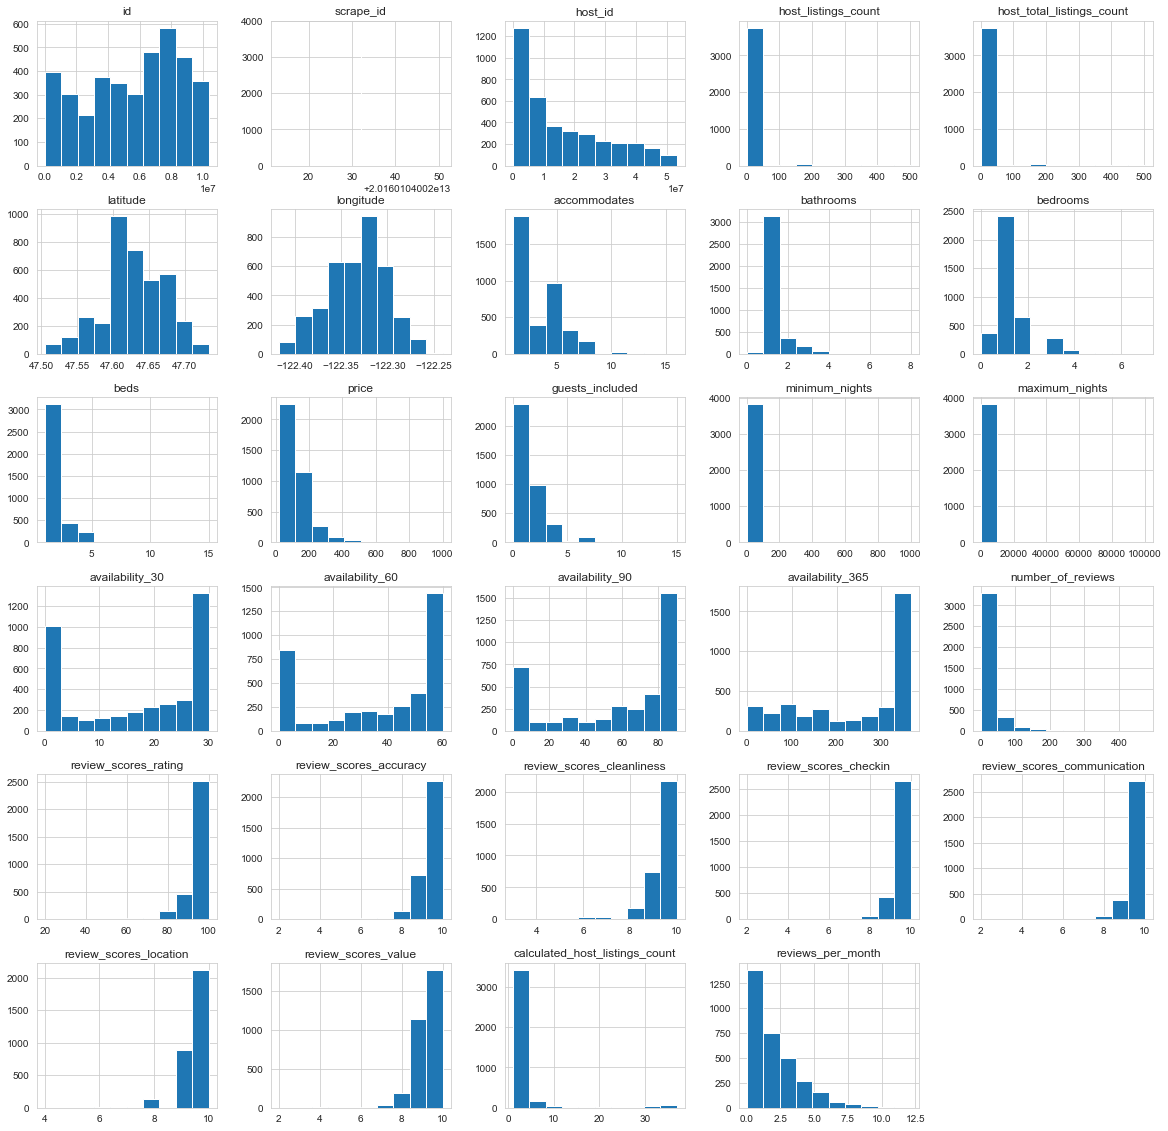

In [89]:
df_listing_new.hist(figsize=(20,20))

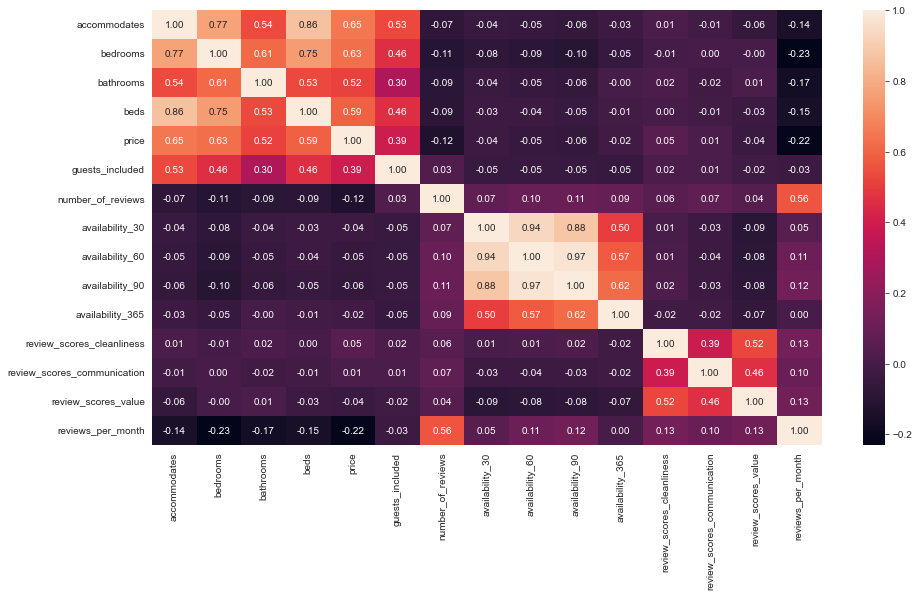

In [90]:
df_listing_num_vals=df_listing_new[['accommodates','bedrooms','bathrooms','beds','price','guests_included','number_of_reviews','availability_30','availability_60','availability_90','availability_365','review_scores_cleanliness','review_scores_communication','review_scores_value','reviews_per_month']]
plt.figure(figsize = (15,8))
sns.heatmap(df_listing_num_vals.corr(), annot=True, fmt=".2f");

In [91]:
df_listing_num_vals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   accommodates                 3818 non-null   int64  
 1   bedrooms                     3812 non-null   float64
 2   bathrooms                    3802 non-null   float64
 3   beds                         3817 non-null   float64
 4   price                        3818 non-null   float64
 5   guests_included              3818 non-null   int64  
 6   number_of_reviews            3818 non-null   int64  
 7   availability_30              3818 non-null   int64  
 8   availability_60              3818 non-null   int64  
 9   availability_90              3818 non-null   int64  
 10  availability_365             3818 non-null   int64  
 11  review_scores_cleanliness    3165 non-null   float64
 12  review_scores_communication  3167 non-null   float64
 13  review_scores_valu

In [92]:
#Modelling with only numerical values to predict the price of an Airbnb

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
fill_df=df_listing_num_vals.apply(fill_mean,axis=0)

#Split into explanatory and response variables
X = fill_df[['accommodates','bedrooms','bathrooms','beds','guests_included','number_of_reviews','availability_30','availability_60','availability_90','availability_365','review_scores_cleanliness','review_scores_communication','review_scores_value','reviews_per_month']]
y = fill_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using only quantitative variables was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))



'The r-squared score for the model using only quantitative variables was 0.5076087143709518 on 1146 values.'

# Categorical values

In [93]:
obj_cat_df=df_listing_new.select_dtypes(include=['object']).copy()
obj_cat_df.shape[1]

45

In [94]:
#number of columns with no missing
np.sum(np.sum(obj_cat_df.isnull())/obj_cat_df.shape[0]==0)

25

In [95]:
np.sum(np.sum(obj_cat_df.isnull())/obj_cat_df.shape[0] > .5)

2

In [96]:
np.sum(np.sum(obj_cat_df.isnull())/obj_cat_df.shape[0] > .75)

0

In [97]:
#Pull a list of the column names of the categorical variables
cat_cols_lst = obj_cat_df.columns

def create_dummy_df(df_listing_new, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df_listing_new = pd.concat([df_listing_new.drop(col, axis=1), pd.get_dummies(df_listing_new[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df_listing_new

In [98]:
df_new = create_dummy_df(df_listing_new, cat_cols_lst, dummy_na=False) #Use your newly created function

# Show a header of df_new to check
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Columns: 12533 entries, id to require_guest_phone_verification_t
dtypes: float64(16), int64(13), uint8(12504)
memory usage: 46.4 MB


In [99]:

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
fill_df=df_new.apply(fill_mean,axis=0)

#Split into explanatory and response variables

X = fill_df
y = fill_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 


lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using both quantitative & categorical vars was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))



'The r-squared score for the model using both quantitative & categorical vars was 0.8197263977890695 on 1146 values.'

In [100]:
# We make further enhancements on the model by using the standard scaler library from scickit learn

In [101]:

#mean function
fill_mean=lambda col: col.fillna(col.mean())
#fill the mean
fill_df=df_new.apply(fill_mean,axis=0)

#Split into explanatory and response variables

X = fill_df

scaler = MinMaxScaler()
ltr=scaler.fit(X)

y = fill_df['price']

#Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42) 

X_train=ltr.fit_transform(X_train)
X_test=ltr.fit_transform(X_test)

lm_model = LinearRegression(normalize=True) # Instantiate
lm_model.fit(X_train, y_train) #Fit
        
#Predict and score the model
y_test_preds = lm_model.predict(X_test) 

#Predict and score the model
y_test_preds = lm_model.predict(X_test) 
"The r-squared score for the model using both quantitative & categorical vars was {} on {} values.".format(r2_score(y_test, y_test_preds), len(y_test))

'The r-squared score for the model using both quantitative & categorical vars was 0.8517464505112949 on 1146 values.'

# Exploratory Data Analysis (EDA) and visualizations

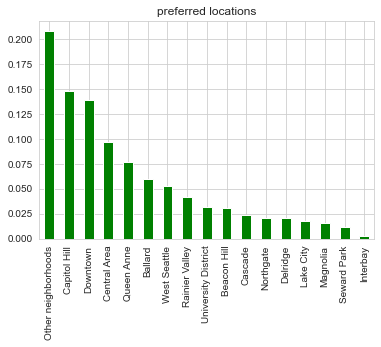

In [102]:
#we look at the listings related to the neighbourhood in seattle
neighbourhood_type = df_listing_new.neighbourhood_group_cleansed.value_counts()#Provide a pandas series of the counts for each Professional status

(neighbourhood_type/df_listing_new.shape[0]).plot(kind="bar",color='green');
plt.title("preferred locations");


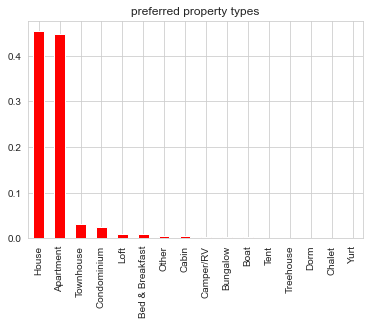

In [103]:
Property_type = df_listing_new.property_type.value_counts()

# we then look at the popular accomodation types in the same areas

(Property_type/df_listing_new.shape[0]).plot(kind="bar",color='red');
plt.title("preferred property types");

# from below we can tell that the two important accomodation types are aprtments and houses.
# therefore we can potentially group the rest 

In [104]:
#GEOSPATIAL VISUALIZATION

cols_to_drop2 = ['host_since','first_review','last_review'] 
df_listing_map = df_listing_new.drop(cols_to_drop2, axis=1)

map_1 = KeplerGl()

map_1 = KeplerGl(height=500, data={"'Airbnb seattle'":df_listing_map})

map_1

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={"'Airbnb seattle'":             id       scrape_id experiences_offered   host_id host_name  \
0…

In [105]:
map_1.save_to_html(file_name='seattle host listings.html')

Map saved to seattle host listings.html!


In [146]:
no_nulls1 = set(df_listing_new.columns[df_listing_new.isnull().mean()==0])#Provide a set of columns with 0 missing values.
no_nulls_view1=len(no_nulls)/df_listing_new.shape[1] #percentage of columns with no_nulls compared to the total number of columns
no_nulls_view1


0.6103896103896104

In [106]:
#TIME SERIES DATA

df_listings['host_since'] = pd.to_datetime(df_listings['host_since'])
df_listings['first_review'] = pd.to_datetime(df_listings['first_review'])

df_listings["host_since"].min(), df_listings["host_since"].max()

(Timestamp('2008-11-10 00:00:00'), Timestamp('2016-01-03 00:00:00'))

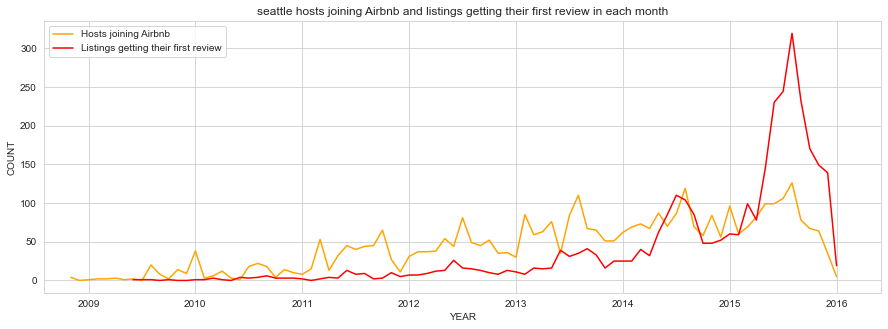

In [107]:
#Time series plots

plt.figure(figsize=(15,5))
df_listings.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
df_listings.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='red')


plt.title('seattle hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-21', '2016-06-20') 
plt.xlabel('YEAR')
plt.ylabel('COUNT')
plt.show()

In [108]:
df_listing_new.host_since=pd.to_datetime(df_listing_new.host_since)
df_listing_new.first_review=pd.to_datetime(df_listing_new.first_review)

In [109]:
df_listing_new.reset_index().set_index('host_since').resample('MS').size()
df_listing_new.reset_index().set_index('first_review').resample('MS').size()

first_review
2009-06-01      1
2009-07-01      1
2009-08-01      1
2009-09-01      0
2009-10-01      1
             ... 
2015-09-01    232
2015-10-01    170
2015-11-01    149
2015-12-01    139
2016-01-01     19
Length: 80, dtype: int64

In [110]:
ts_host_since = pd.DataFrame(df_listing_new.reset_index().set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df_listing_new.reset_index().set_index('first_review').resample('MS').size())


ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [111]:
#Plots the original time series and its decomposition into trend, seasonal and residual.
   
def decompose_time_series(df_listings, title=''):
# Decomposing the time series
    decomposition = seasonal_decompose(df_listings)
    
# Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
# Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df_listings, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

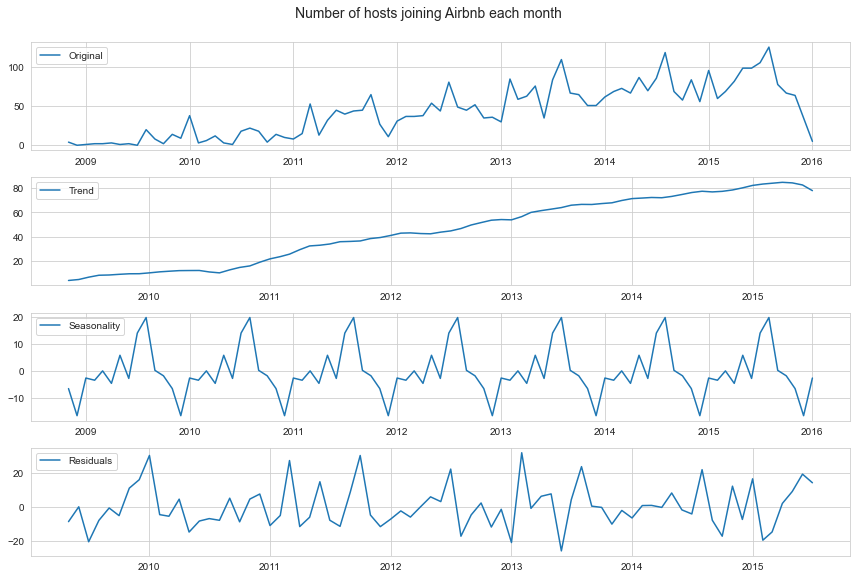

In [112]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

In [113]:
# show visualization linked to price overtime 

Text(0, 0.5, 'Price in Dollars($)')

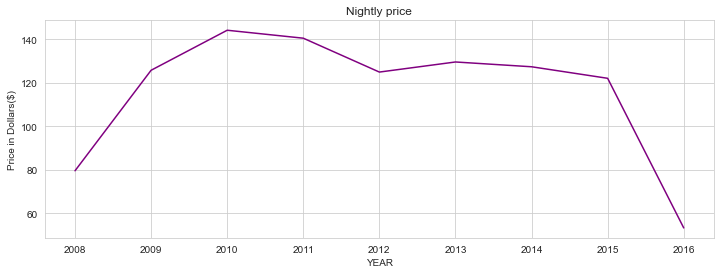

In [114]:
df_listing_new["year"] = df_listing_new["host_since"].dt.year
df_price_nbr=df_listing_new.groupby(['year']).mean()['price']
df_price_nbr.plot(figsize=(12,4),color='purple')
plt.title('Nightly price')
plt.xlabel('YEAR')
plt.ylabel('Price in Dollars($)')

In [115]:
df_object_col_drop['weekly_price'] = df_object_col_drop['weekly_price'].apply(convert_price_to_float).astype('float')
df_object_col_drop['monthly_price'] = df_object_col_drop['monthly_price'].apply(convert_price_to_float).astype('float')

Text(0, 0.5, 'monthly Price in Dollars($)')

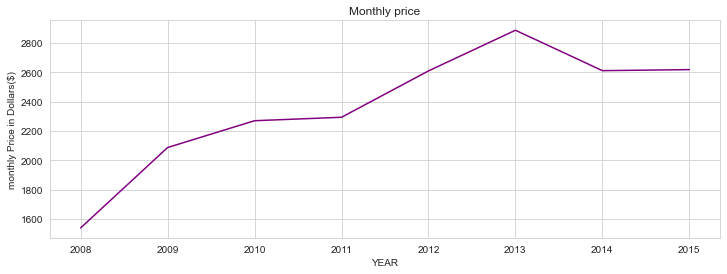

In [116]:
df_listing_new["month"] = df_listing_new["host_since"].dt.month
df_price_nbr=df_listing_new.groupby(['year']).mean()['monthly_price']
df_price_nbr.plot(figsize=(12,4),color='purple')
plt.title('Monthly price')
plt.xlabel('YEAR')
plt.ylabel('monthly Price in Dollars($)')

Text(0, 0.5, 'weekly Price in Dollars($)')

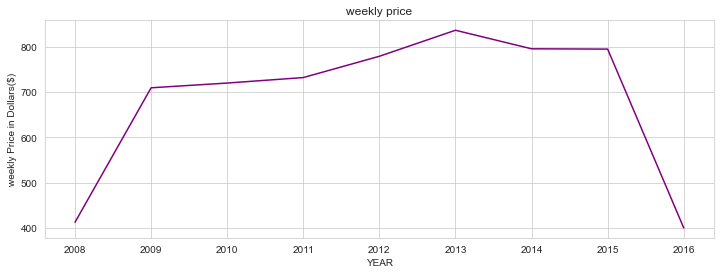

In [117]:
df_listing_new["month"] = df_listing_new["host_since"].dt.month
df_price_nbr=df_listing_new.groupby(['year']).mean()['weekly_price']
df_price_nbr.plot(figsize=(12,4),color='purple')
plt.title('weekly price')
plt.xlabel('YEAR')
plt.ylabel('weekly Price in Dollars($)')

In [118]:
df_listing_new["nightly_price"] = df_listing_new["price"]
neighbourhood=pd.pivot_table(df_listing_new,values=['nightly_price','host_listings_count','weekly_price','monthly_price'],index=['neighbourhood_group_cleansed'],
            aggfunc={'nightly_price': np.mean,
                     'weekly_price':np.mean,
                     'monthly_price':np.mean,
                     'host_listings_count':np.sum
                    }) 
neighbourhood.sort_values(by='host_listings_count',ascending='true')

,host_listings_count,monthly_price,nightly_price,weekly_price
neighbourhood_group_cleansed,,,,
Interbay,23.0,2224.000000,109.727273,696.428571
Delridge,106.0,1869.315789,83.278481,585.208333
Seward Park,131.0,1880.761905,108.477273,571.692308
Magnolia,139.0,2772.666667,177.672131,927.322581
Northgate,149.0,2015.244444,88.550000,527.959184
Cascade,310.0,3151.605263,140.101124,925.740000
Beacon Hill,333.0,2414.976744,94.669492,649.160000
West Seattle,440.0,2698.789474,141.359606,845.314050
Lake City,455.0,1867.000000,92.671642,558.555556


In [144]:
df_listing_new['weekly_price']=df_listing_new['weekly_price'].fillna(method='ffill')

<AxesSubplot:xlabel='host_since'>

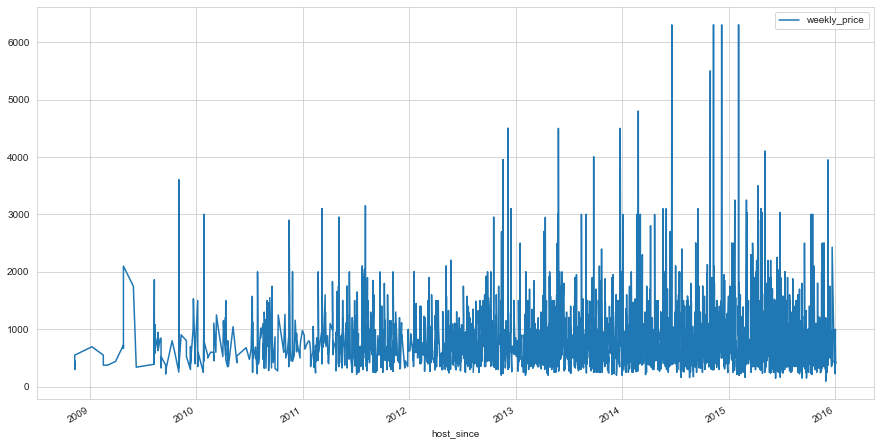

In [145]:
df_listing_new[['weekly_price']].plot(subplots=False,figsize=(15,8))

In [121]:

accomodation_type=pd.pivot_table(df_listing_new,values=['nightly_price','host_listings_count','weekly_price','monthly_price'],index=['property_type'],
            aggfunc={'nightly_price': np.mean,
                     'weekly_price':np.mean,
                     'monthly_price':np.mean,
                     'host_listings_count':np.sum
                    }) 
accomodation_type.sort_values(by='host_listings_count',ascending='true')
accomodation_type.dropna(axis=0).sort_values(by='host_listings_count',ascending='true')

,host_listings_count,monthly_price,nightly_price,weekly_price
property_type,,,,
Chalet,5.0,2325.000000,98.500000,587.500000
Boat,12.0,2197.500000,282.375000,602.500000
Bungalow,16.0,2140.000000,115.615385,648.571429
Camper/RV,31.0,1800.666667,120.461538,458.833333
Cabin,41.0,1544.666667,104.666667,519.000000
Loft,79.0,2472.083333,135.700000,901.750000
Bed & Breakfast,98.0,2385.416667,112.054054,697.684211
Townhouse,243.0,2924.888889,129.457627,844.649123
Condominium,441.0,3259.000000,151.109890,1018.023256


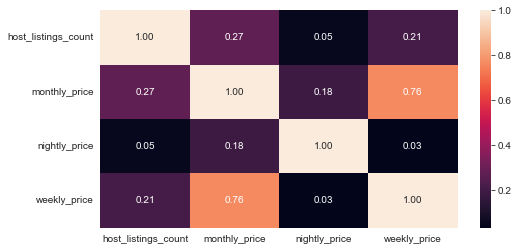

In [122]:
plt.figure(figsize = (8,4))
sns.heatmap(accomodation_type.corr(), annot=True, fmt=".2f");